<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# ⛽ Fuel efficiency Prediction

Provided with the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset, we will predict the **fuel efficiency** of the late-1970s and early 1980s automobiles, leveraging features such as cylinders, displacement, horsepower, weight, etc. 

It is a very small dataset and there are only a few features. We will first build a linear model and a neural network, evaluate their performances, and then leverage an auto-machine learning (AutoML) library called [TPOT](https://github.com/EpistasisLab/tpot) to see how it can be used to search over many ML model acchitectures.

# 📚 Learning Objectives

By the end of this session, you will be able to

- understand the core building blocks of a neural network
- understand what dense and activation layers do
- build, train, and evaluate neural networks
- perform AutoML to search for optimal tree-based pipeline for a regression task 

Note: [State of Data Science and Machine Learning 2021](https://www.kaggle.com/kaggle-survey-2021) by Kaggle shows that the most commonly used algorithms were linear and logtistic regressions, followed closely by decision trees, random forests, and gradient boosting machines (are you surprised?). Multilayer perceptron, or artificial neural networks are not yet the popular tools for tabular/structured data; see more technical reasons in papers: [Deep Neural Networks and Tabular Data: A Survey](https://arxiv.org/abs/2110.01889), [Tabular Data: Deep Learning is Not All You Need](https://arxiv.org/abs/2106.03253). For this assignment, the main purpose is for you to get familiar with the basic building blocks in constructing neural networks before we dive into more specialized neural network architectures.


**IMPORTANT**

You only need to run the following cells if you're completing the assignment in Google Collab. If you've already installed these libraries locally, you can skip installing these libraries.

In [1]:
# Connect colab to your Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q seaborn ## Use seaborn for pairplot
!pip install -q tpot  # Use TPOT for automl

     |████████████████████████████████| 87 kB 3.1 MB/s 
     |████████████████████████████████| 139 kB 40.5 MB/s 
     |████████████████████████████████| 192.9 MB 72 kB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


# Task 1 - Data: Auto MPG dataset

1. The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/). First download and import the dataset using `pandas`:


In [80]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [
  'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
  'Acceleration', 'Model Year', 'Origin'
  ]

dataset = pd.read_csv(url, names=column_names, na_values='?', 
                      comment='\t', sep=' ', skipinitialspace=True)

In [81]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


2. The dataset contains a few unknown values, we drop those rows to keep this initial tutorial simple. Use `pd.DataFrame.dropna()`:

In [82]:
dataset = dataset.dropna()

3. The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [83]:
dataset['Origin'] = dataset['Origin'].replace({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [84]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


4. Split the data into training and test sets. To reduce the module importing overhead, instead of `sklearn.model_selection.train_test_split()`, use `pd.DataFrame.sample()` to save 80% of the data aside to `train_dataset`, set the random state to be 0 for reproducibility. 

   Then use `pd.DataFrame.drop()` to obtain the `test_dataset`.

In [85]:

train_dataset = dataset.sample(frac=0.8,random_state=200) #random state is a seed value
test_dataset = dataset.drop(train_dataset.index)

5. Review the pairwise relationships of a few pairs of columns from the training set. 
   
   The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

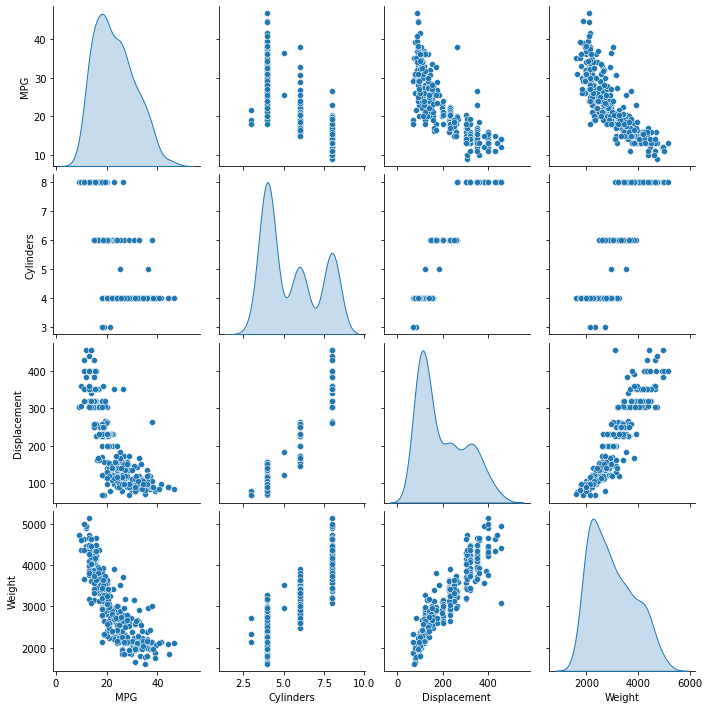

In [86]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde');

Let's also check the overall statistics. Note how each feature covers a very different range:

In [87]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.158280,7.763197,9.0,17.000,22.0,28.00,46.6
Cylinders,314.0,5.506369,1.707423,3.0,4.000,4.0,8.00,8.0
Displacement,314.0,196.597134,104.059431,68.0,107.000,151.0,302.00,455.0
Horsepower,314.0,105.824841,38.413480,46.0,76.000,95.0,130.00,230.0
Weight,314.0,2991.866242,842.373890,1613.0,2236.750,2824.0,3618.25,5140.0
Acceleration,314.0,15.391083,2.591307,8.0,13.625,15.4,17.00,24.8
Model Year,314.0,75.974522,3.727026,70.0,73.000,76.0,79.00,82.0
Europe,314.0,0.156051,0.363483,0.0,0.000,0.0,0.00,1.0
Japan,314.0,0.210191,0.408095,0.0,0.000,0.0,0.00,1.0
USA,314.0,0.633758,0.482546,0.0,0.000,1.0,1.00,1.0


5. Split features from labels

  Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [88]:
train_features = train_dataset.drop('MPG', axis=1)
test_features = test_dataset.drop('MPG', axis=1)

train_labels = train_dataset[['MPG']]
test_labels = test_dataset[['MPG']]

# Task 2 - Normalization Layer

It is good practice to normalize features that use different scales and ranges. Although a model *might* converge without feature normalization, normalization makes training much more stable.

Similar to scikit-learn, tensorflow.keras offers a list of [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) so that you can build and export models that are truly end-to-end.

1. The Normalization layer ([`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) is a clean and simple way to add feature normalization into your model. The first step is to create the layer:

In [89]:
normalizer =  tf.keras.layers.Normalization(axis=-1)

2. Then, fit the state of the preprocessing layer to the data by calling [`Normalization.adapt`](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method):

In [90]:
normalizer.adapt(train_features)
normalizer(train_features)

<tf.Tensor: shape=(314, 9), dtype=float32, numpy=
array([[-0.884, -0.882, -0.804, ..., -0.43 , -0.516,  0.76 ],
       [-0.884, -0.728,  0.239, ...,  2.326, -0.516, -1.315],
       [-0.884, -1.132, -0.934, ...,  2.326, -0.516, -1.315],
       ...,
       [-0.884, -0.959, -0.465, ..., -0.43 ,  1.938, -1.315],
       [-0.884, -1.016, -0.986, ..., -0.43 ,  1.938, -1.315],
       [-0.884, -0.545, -0.439, ..., -0.43 , -0.516,  0.76 ]],
      dtype=float32)>

We can see the feature mean and variance are stored in the layer:

In [91]:
print(f'feature mean: {normalizer.mean.numpy().squeeze()}\n')
print(f'feature variance: {normalizer.variance.numpy().squeeze()}')

feature mean: [   5.506  196.597  105.825 2991.866   15.391   75.975    0.156    0.21
    0.634]

feature variance: [     2.906  10793.881   1470.896 707334.         6.693     13.846
      0.132      0.166      0.232]


When the layer is called, it returns the input data, with each feature independently normalized:

In [92]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.   105.    75.  2230.    14.5   78.     0.     0.     1. ]]

Normalized: [[-0.88 -0.88 -0.8  -0.91 -0.34  0.54 -0.43 -0.52  0.76]]


# Task 3 - Linear regression 📈

Before building a deep neural network model, start with linear regression using all the features.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in this multivariate linear regression model:

- Normalize all the input features using the `tf.keras.layers.Normalization` preprocessing layer. You have defined this ealier as `normalizer`.
- Apply a linear transformation ($y = mx+b$ where $m$ is a matrix and $b$ is a vector.) to produce 1 output using a linear layer ([`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

1. Build the Keras Sequential model:

In [124]:
def build_model():
  model = keras.Sequential([
    normalizer,
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.1)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer)
  return model

In [125]:
# Force converting all column datatypes into integer
train_features = train_features.apply(pd.to_numeric) # convert all columns of DataFrame
train_features['Europe'] = train_features['Europe'].astype('int')
train_features['Japan'] = train_features['Japan'].astype('int')
train_features['USA'] = train_features['USA'].astype('int')
train_features.dtypes

Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Europe            int64
Japan             int64
USA               int64
dtype: object

In [126]:
model = build_model()

In [127]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_15 (Dense)            (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


2. This model will predict `'MPG'` from all features in `train_features`. Run the untrained model on the first 10 data points / rows using `Model.predict()`. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [128]:
model.predict(train_features[:10])

array([[-0.347],
       [-0.759],
       [ 0.052],
       [-0.22 ],
       [ 0.084],
       [-1.093],
       [ 0.367],
       [ 0.774],
       [-0.326],
       [ 1.643]], dtype=float32)

3. When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y = mx + b$) have a shape of (9, 1):

In [129]:
model.layers[1].kernel

<tf.Variable 'dense_15/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.753],
       [ 0.251],
       [ 0.684],
       [-0.133],
       [ 0.458],
       [-0.494],
       [-0.264],
       [ 0.492],
       [ 0.27 ]], dtype=float32)>

5. Use Keras `Model.fit` to execute the training for 100 epochs, set the verbose to 0 to suppress logging and keep 20% of the data for validation:

In [130]:
%%time
# Display training progress by printing a single dot for each completed epoch
EPOCHS = 100

history = model.fit(
  train_features, train_labels,
  epochs=EPOCHS, verbose=0, validation_split = 0.20)

CPU times: user 4.11 s, sys: 173 ms, total: 4.29 s
Wall time: 5.48 s


6. Visualize the model's training progress using the stats stored in the `history` object:

In [131]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,10.509660,12.192505,95
96,10.493793,12.144103,96
97,10.529069,12.168975,97
98,10.579440,12.107087,98
99,10.496867,12.189174,99


In [132]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 20])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
  plt.show()

Use `plot_loss(history)` provided to visualize the progression in loss function for training and validation data sets. 

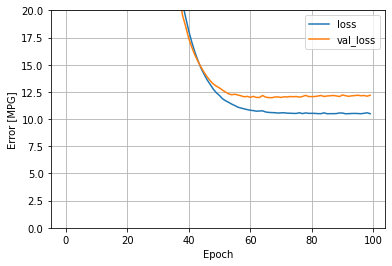

In [133]:
plot_loss(history)

7. Collect the results on the test set for later using [`Model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate)

In [134]:
# You can also evaluate or predict on a dataset.
result = {}
print("Evaluate")
result['linear_model'] = model.evaluate(test_features,test_labels)
result

Evaluate
3/3 [==============================] - 0s 3ms/step - loss: 11.0610


{'linear_model': 11.061002731323242}

# Task 4 - Regression with a deep neural network (DNN)

You just implemented a linear model for multiple inputs. Now, you are ready to implement multiple-input DNN models.

The code is very similar except the model is expanded to include some "hidden" **non-linear** layers. The name "hidden" here just means not directly connected to the inputs or outputs.

* The normalization layer, as before (with `normalizer` for a multiple-input model).
* Two hidden, non-linear, [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with the ReLU (`relu`) activation function nonlinearity. One way is to set parameter `activation` inside `Dense` Set the number of neurons at each layer to be 64. 
* A linear `Dense` single-output layer. 



1. Include the model and `compile` method in the `build_and_compile_model` function below. 

In [138]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential # YOUR CODE HERE 
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
  return model

2. Create a DNN model with `normalizer` (defined earlier) as the normalization layer:



In [139]:
def build_model():
  model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam()

  model.compile(loss='mean_squared_error',
                optimizer=optimizer)
  return model

3. Inspect the model using `Model.summary()`. This model has quite a few more trainable parameters than the linear models:

In [140]:
model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_16 (Dense)            (None, 64)                640       
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


4. Train the model with Keras `Model.fit`:

In [141]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.82 s, sys: 220 ms, total: 5.04 s
Wall time: 4.48 s


5. Visualize the model's training progress using the stats stored in the history object. 

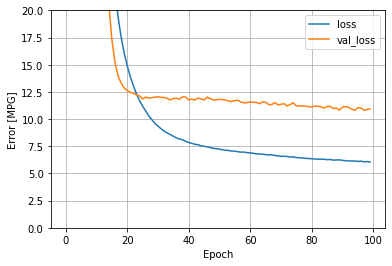

In [142]:
plot_loss(history)


Do you think the DNN model is overfitting? What gives away? 

The training and testing sets are pretty far apart in the above graph compared to the graph we generated before. 



6. Let's save the results for later comparison.

In [109]:
result['dnn_model'] = model.evaluate(test_features, test_labels, verbose=0)
result

{'linear_model': 11.291399002075195, 'dnn_model': 6.646728515625}

# Task 5 - Make predictions 🔮

1. Since both models have been trained, we can review their test set performance:

In [110]:
pd.DataFrame(result, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,11.291399
dnn_model,6.646729


These results match the validation error observed during training.

2. We can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss. Use `.flatten()`.

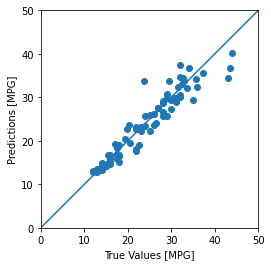

In [111]:
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


3. It appears that the model predicts reasonably well. Now, check the error distribution:

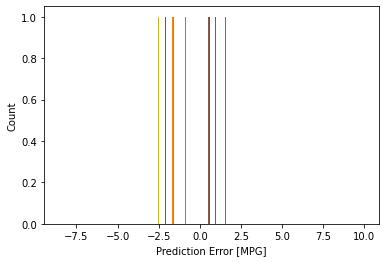

In [114]:
test_predictions=test_predictions.reshape(78,1)
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

4. Save it for later use with `Model.save`:

In [116]:
model.save('dnn_model')

5. Reload the model with `Model.load_model`; it gives identical output:

In [119]:
reloaded = tf.keras.models.load_model('dnn_model')

result['reloaded'] = reloaded.evaluate(test_features, test_labels, verbose=0)

In [120]:
pd.DataFrame(result, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,11.291399
dnn_model,6.646729
reloaded,6.646729


# Task 6 - Nonlinearity

We mentioned that the `relu` activation function introduce non-linearity; let's visualize it. Yet there are six numerical features and 1 categorical features, it is impossible to plot all the dimensions on a 2D plot; we need to simplify/isolate it. 

Note: in this task, code is provided; the focus in on understanding. 

1. We focus on the relationship between feature `Displacement` and target `MPG`. 
  
  To do so, create a new dataset of the same size as `train_features`, but all other features are set at their median values; then set the `Displacement` between 0 and 500. 

In [135]:
fake = np.outer(np.ones(train_features.shape[0]), train_features.median())
fake = pd.DataFrame(fake, columns = train_features.columns)
fake.Displacement = np.linspace(0, 500, train_features.shape[0])

2. Create a plotting function to a) visualize real values between `Displacement` and `MPG` from the training dataset in scatter plot b) overlay the predicted MPG from Displacement varying from 0 to 500, but holding all other features constant. 

In [136]:
def plot_displacement(x, y):
  plt.scatter(train_features['Displacement'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Displacement')
  plt.ylabel('MPG')
  plt.legend()

3. Visualize predicted MPG using the linear model.

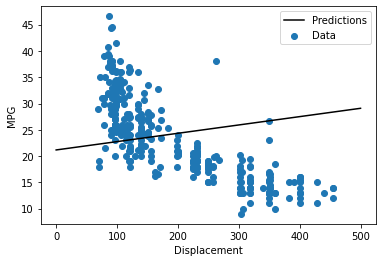

In [137]:
plot_displacement(fake.Displacement, model(fake))

4. Visualize predicted MPG using the neural network model. Do you see an improvement/non-linearity from the linear model? 

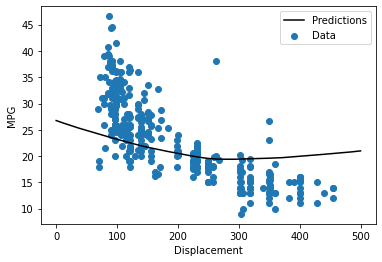

In [143]:
plot_displacement(fake.Displacement, model.predict(fake))

5. What are the other activation functions? Check the list of [activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations). 
  
   Optional. Modify the DNN model with a different activation function, and fit it on the data; does it perform better? 

6. Overfitting is a common problem for DNN models, how should we deal with it? Check [Regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) on tf.keras. Any other techiniques that are invented for neural networks?

In [146]:
# 1. Simplifying The Model:
 
# The first step when dealing with overfitting is to decrease the complexity of the model. To decrease the complexity, we can simply remove layers or reduce the number of neurons to make the network smaller. While doing this, it is important to calculate the input and output dimensions of the various layers involved in the neural network. There is no general rule on how much to remove or how large your network should be. But, if your neural network is overfitting, try making it smaller.

 

# 2. Early Stopping:
 
# Early stopping is a form of regularization while training a model with an iterative method, such as gradient descent. Since all the neural networks learn exclusively by using gradient descent, early stopping is a technique applicable to all the problems. This method update the model so as to make it better fit the training data with each iteration. Up to a point, this improves the model’s performance on data on the test set. Past that point however, improving the model’s fit to the training data leads to increased generalization error. Early stopping rules provide guidance as to how many iterations can be run before the model begins to overfit.

# Task 7 - AutoML with TPOT 🫖

1. Instantiate and train a TPOT auto-ML regressor.

    The parameters are set fairly arbitrarily (if time permits, you shall experiment with different sets of parameters after reading [what each parameter does](http://epistasislab.github.io/tpot/api/#regression)). Use these parameter values:

    `generations`: 10

    `population_size`: 40

    `scoring`: negative mean absolute error; read more in [scoring functions in TPOT](http://epistasislab.github.io/tpot/using/#scoring-functions)

    `verbosity`: 2 (so you can see each generation's performance)

    The final line with create a Python script `tpot_products_pipeline.py` with the code to create the optimal model found by TPOT.

In [148]:
%%time
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=10, 
                     population_size=40,
                     scoring='accuracy',
                     verbosity=2,
                     random_state=42)
tpot.fit(train_features, train_labels)
print(f"Tpop score on test data: {tpot.score(test_features, test_labels):.2f}")
tpot.export('tpot_mpg_pipeline.py')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimization Progress:   0%|          | 0/440 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -inf


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

ValueError: ignored

2. Examine the model pipeline that TPOT regressor offers. If you see any model, function, or class that are not familiar, look them up! 

  Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate. 

In [149]:
cat tpot_mpg_pipeline.py

cat: tpot_mpg_pipeline.py: No such file or directory


3. Optional: Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_mpg_pipeline.py` to build a model on our training set and make predictions on the test set. Save the predictions as `y_pred`, and compute appropriate evaluation metric. You may find that for this simple data set, the nueral network we built outperforms the tree-based model, yet note it is not a conclusion that we can be generalized for all tabular data. 

# Task 8 - Model Explainability

Last week, we introduced model explainability with SHAP and will continue to incorporate it as part our model output this week.  You can use the [Kernal Explainer](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html) for explainability of both the Neural Networks and the TPOT classifier.  

**NOTE**: If you're using Collab to complete this assignment, please run the following cell - otherwise you can skip it.

In [ ]:
!pip install -q shap

In [ ]:
# YOUR CODE GOES HERE!

# Task 9 - Taking it to the Next Level! 📶

Let's take our models and make a model comparison demo like we did last week, but this time you're taking the lead!  
    
1. Save your training dataset as a CSV file so that it can be used in the Streamlit app.
1. Build a results DataFrame and save it as a CSV so that it can be used in the Streamlit app.
1. In Tab 1 - Raw Data:
* Display your training dataset in a Streamlit DataFrame (`st.DataFrame`).
* Build 1-2 interactive Plotly visualizations that explore the dataset (correlations, scatterplot, etc.)
2. In Tab 2 - Model Results:
* Display your performance metrics appropriately using 2-3 metrics for model comparison.
3. In Tab 3 - Model Explainability:
* Make local and global explainability plots to compare two models at a time side-by-side.  

[Here](https://www.kaggle.com/code/elsa155026/uciheart-kernel-shap-and-interactive-visualization/notebook) is a good example if how to create some different explainability plots using Plotly.

# Additional Resources

- [Tensorflow playground](https://playground.tensorflow.org/) for an interactive experience to understand how nueral networkds work.

- [An Introduction to Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/) covers embeddings for categorical variables. 

- [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/) demonstrates using `class_weight` to handle imbalanced classification problems. 

# Acknowledgement and Copyright

##### Acknowledgement

This notebook is adapted from [tensorflow/keras tuorial - regression](https://www.tensorflow.org/tutorials/keras/regression)

##### Copyright 2018 The TensorFlow Authors.

@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

@title MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.